/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


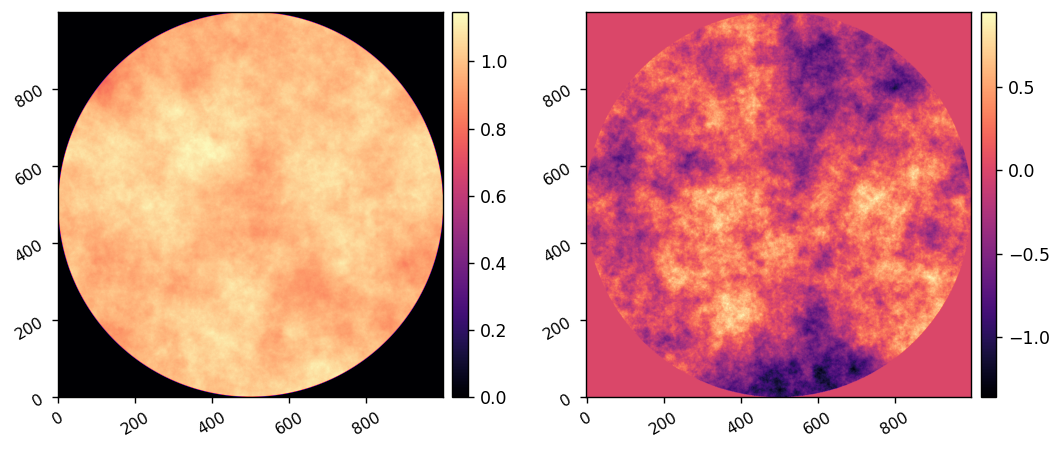

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.scoob_rmad as rmad
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc as adefc

wfe_amp = utils.load_fits('example_wfe_amp.fits')
wfe_phs = utils.load_fits('example_wfe_phs.fits')
WFE = wfe_amp * xp.exp(1j*wfe_phs)
imshow2(wfe_amp, wfe_phs)



# Test the forward model parameters.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


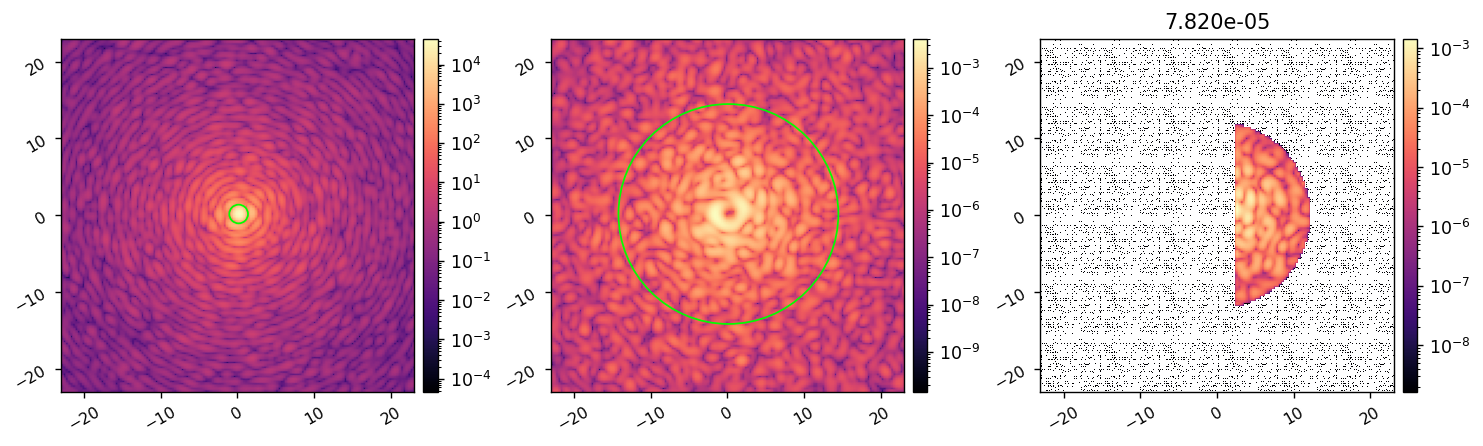

In [2]:
reload(rmad)
I = rmad.MODEL()
I.WFE = WFE

I.flip_dm = 1
I.flip_lyot_ud = 1
I.det_rotation = -7.5

I.setattr('use_vortex', False)
ref_psf = I.snap()
I.setattr('Imax_ref', xp.max(ref_psf))
I.setattr('use_vortex', True)
ref_coro_im = I.snap()

iwa = 2.5
owa = 12
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=iwa, rotation=rot)
mean_ni = xp.mean(ref_coro_im[control_mask])

psf_center = (I.psf_pixelscale_lamD/2, I.psf_pixelscale_lamD/2)
imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, '', '', f'{mean_ni:.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamD, 
        patches1=[Circle(psf_center, 1.22, fill=False, color='lime')], 
        patches2=[Circle(psf_center, I.control_rad, fill=False, color='lime')],
        )

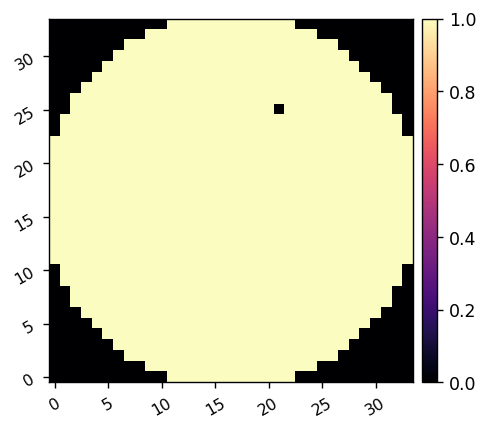

In [15]:
imshow1(I.dm_mask)

Oversampling > 2x suggested for reliable results in Fresnel propagation.


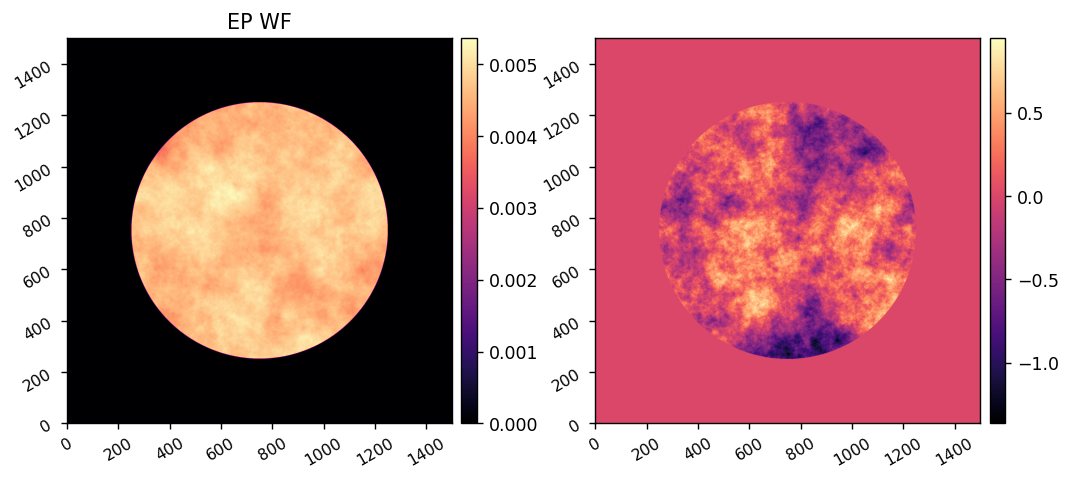

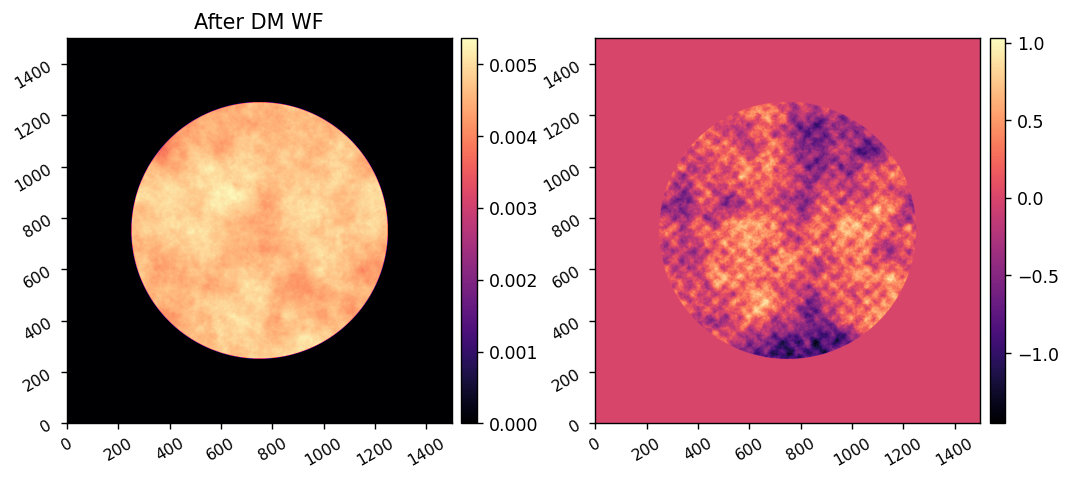

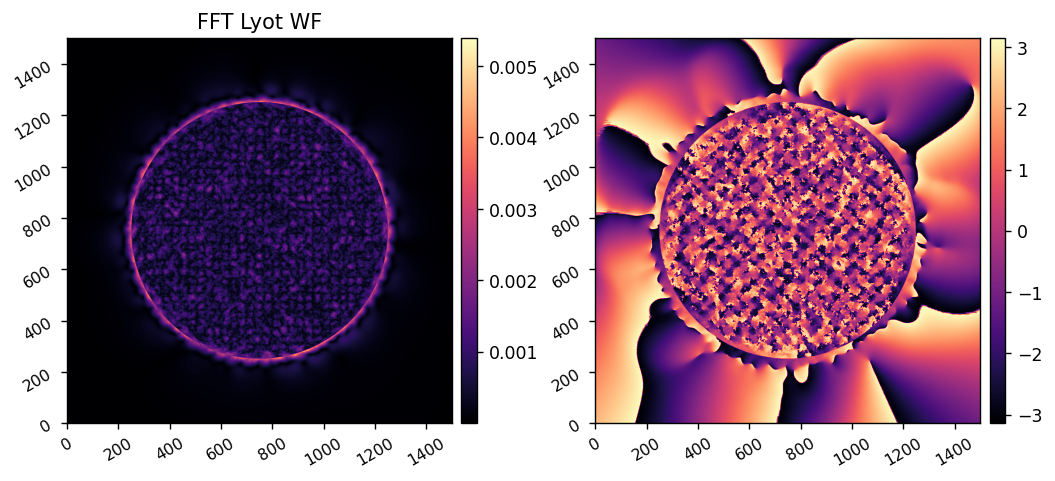

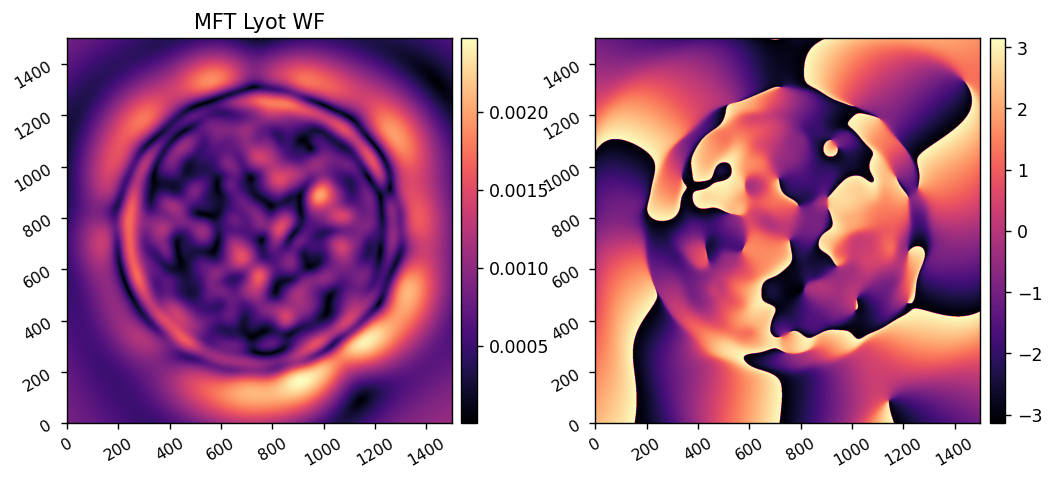

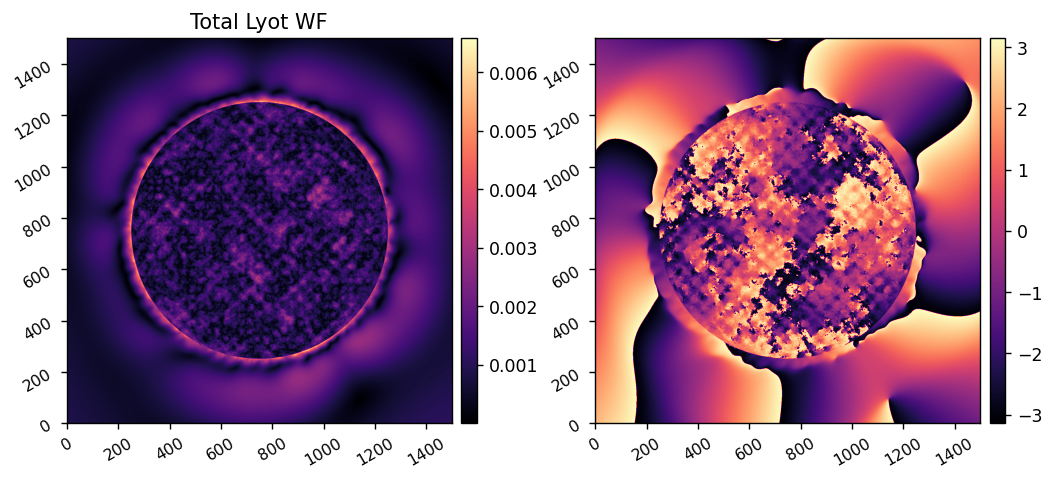

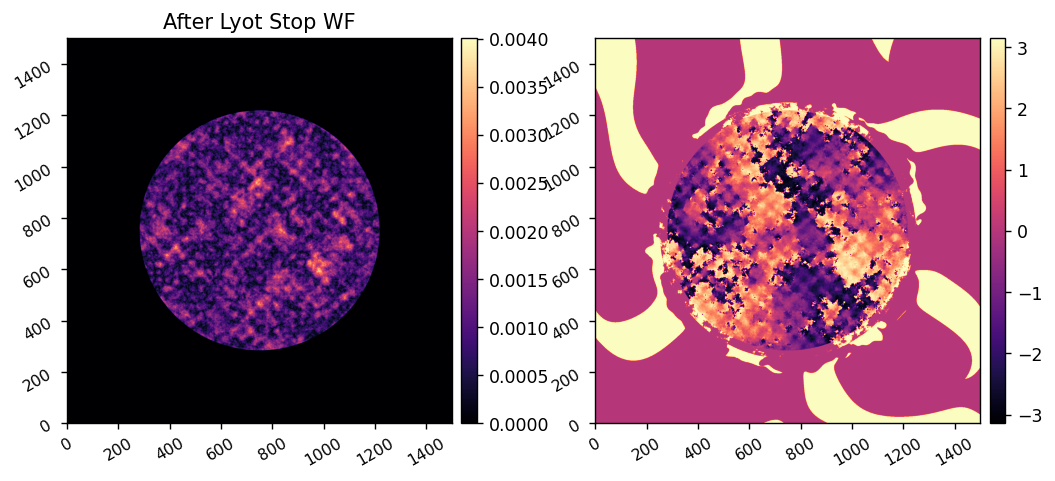

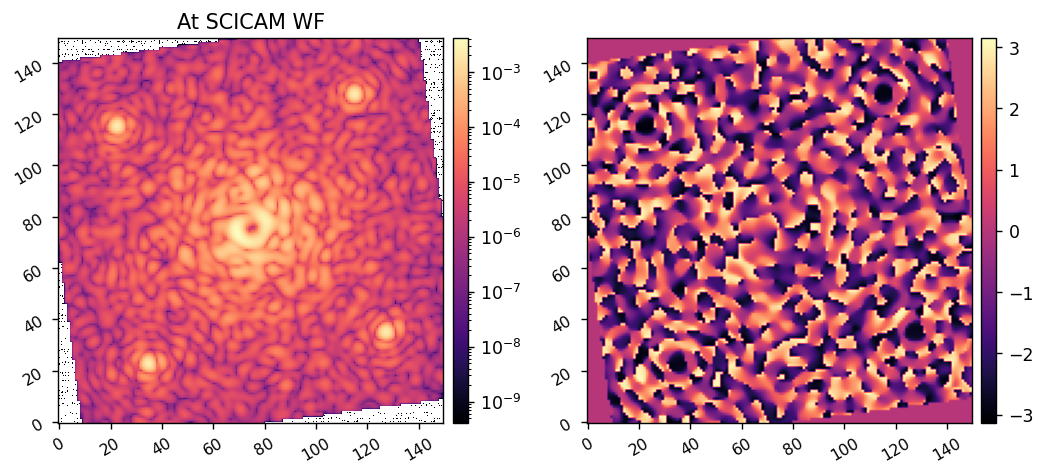

In [65]:
reload(rmad)
reload(scoobpsf.dm)
reload(lina.utils)
M = rmad.MODEL()
M.WFE = WFE

# M.flip_dm = 1
# M.flip_lyot_ud = 1
# M.det_rotation = -7.5

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

acts = np.zeros(M.Nacts)
acts = 20e-9*lina.utils.make_f(h=10, w=6, shift=(0,0))[M.dm_mask]
acts = 20e-9*lina.utils.make_fourier_command(x_cpa=17, y_cpa=17)[M.dm_mask]
fpwf = M.forward(acts, use_vortex=True, plot=True)


	Cost-function J_delE: 0.133
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.133
	Total cost-function value: 1.000



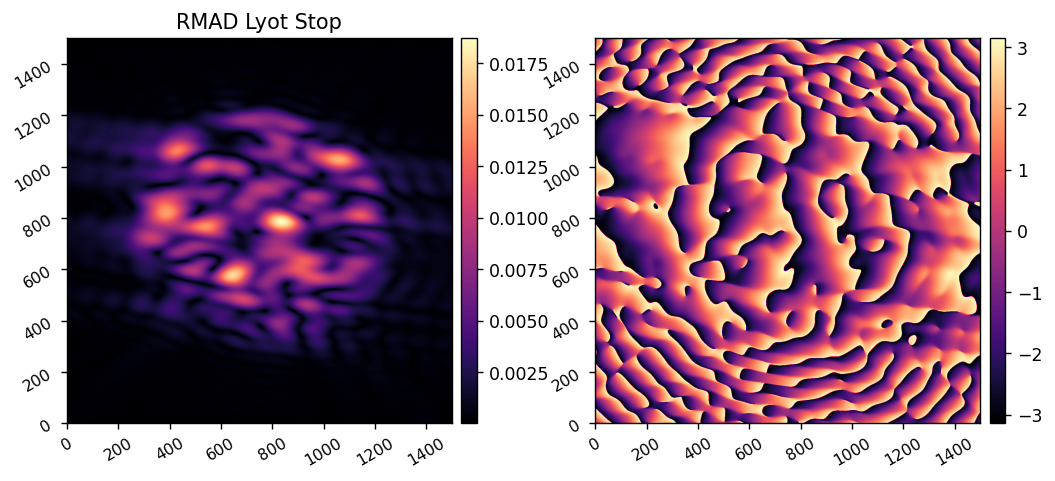

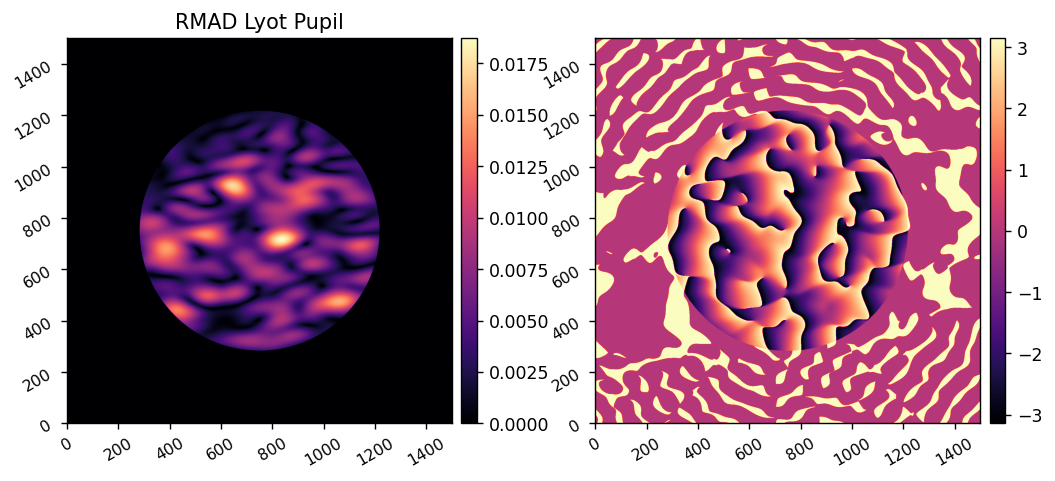

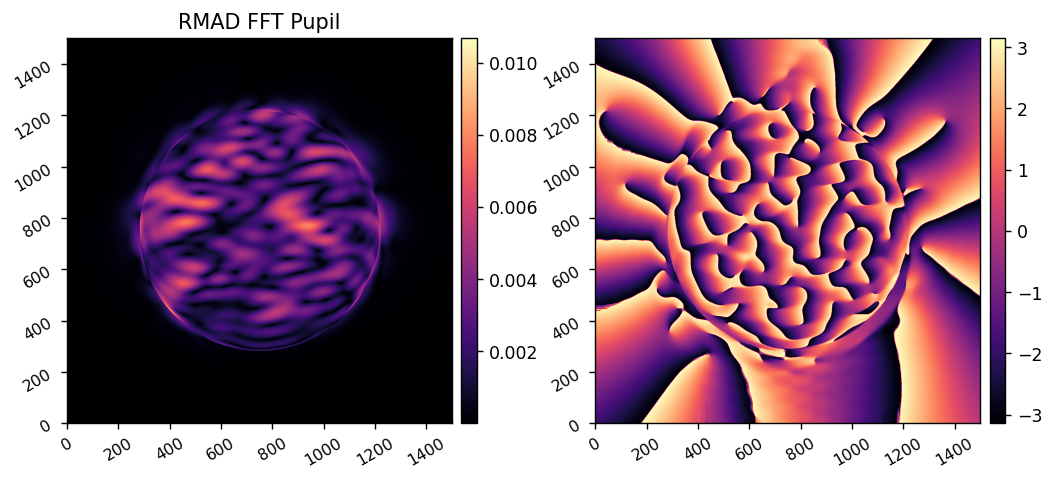

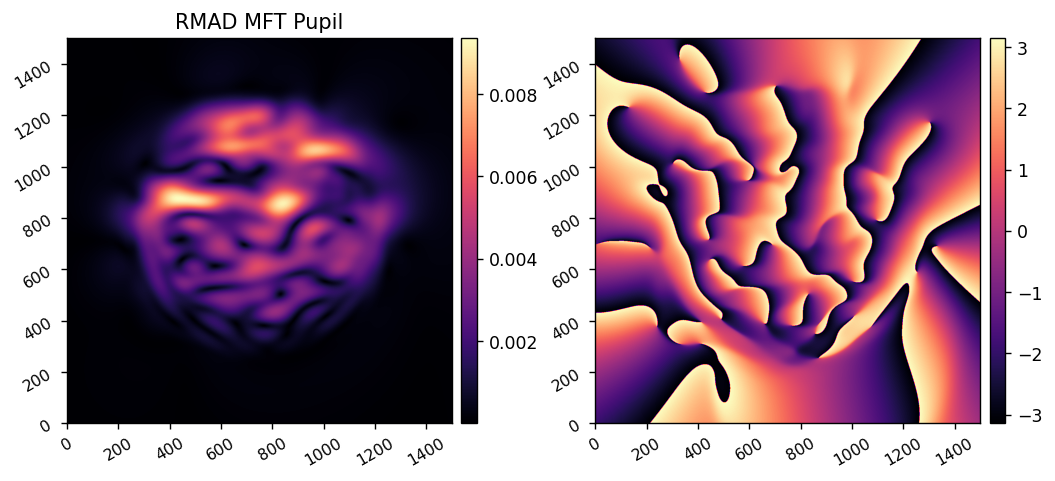

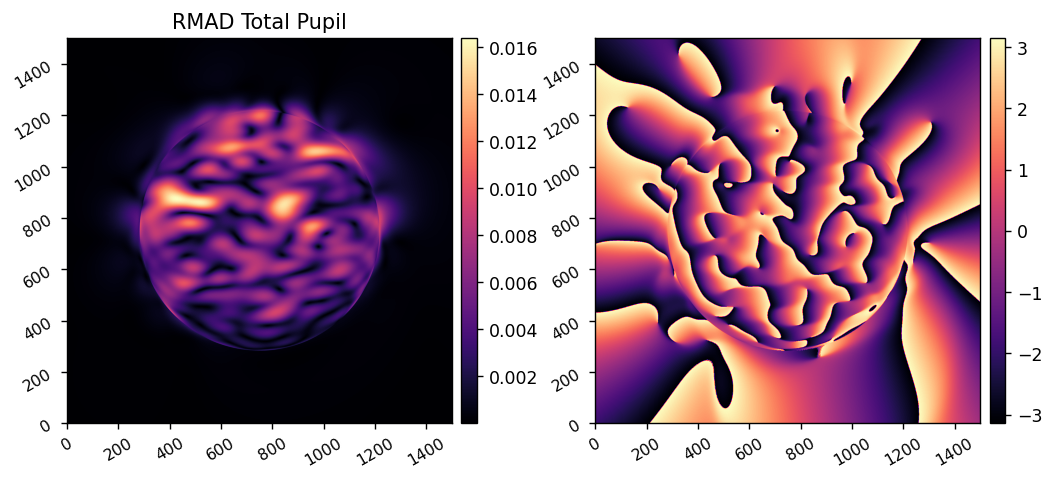

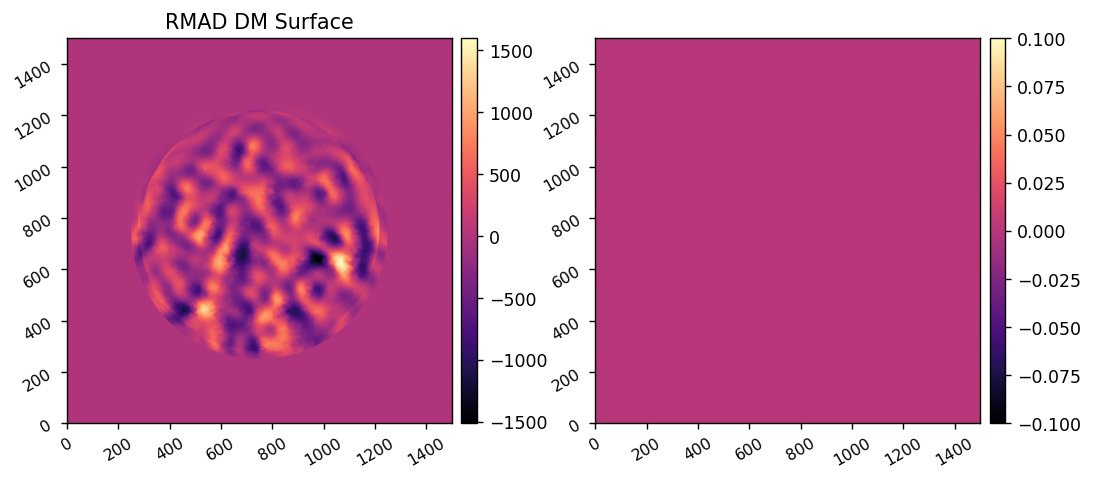

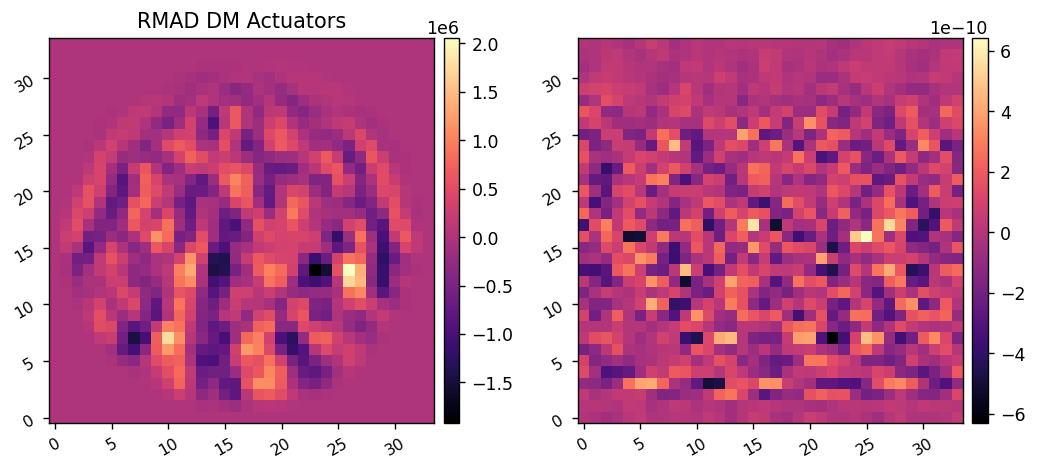

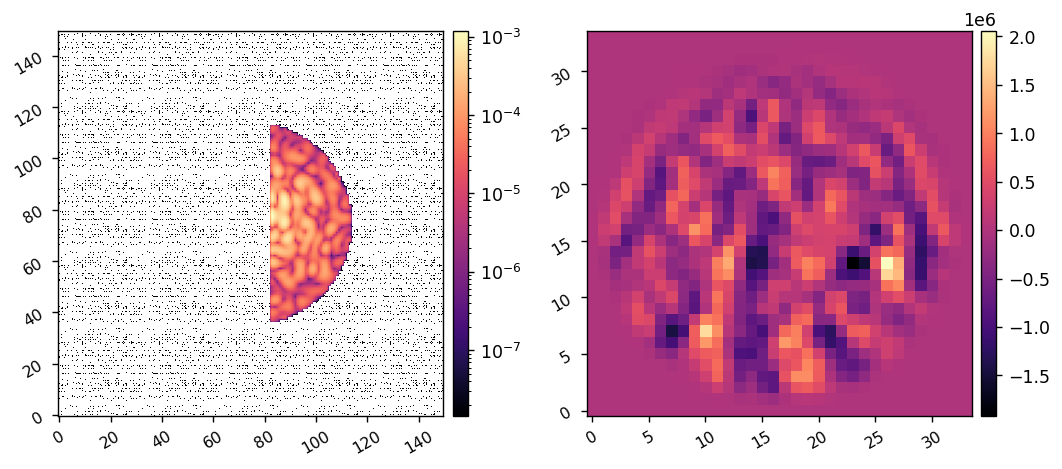

In [66]:
reload(rmad)

acts = np.zeros(I.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
r_cond = 1e-2

del_acts = np.zeros(M.Nacts)
J, dJ_dA = rmad.val_and_grad(del_acts, M, acts, E_ab, r_cond, control_mask, verbose=True, plot=True)

dm_grad = rmad.acts_to_command(dJ_dA, M.dm_mask)
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [88]:

acts = np.zeros(I.Nacts)
acts = fits.getdata('ad_test_acts.fits')

I.set_dm(rmad.acts_to_command(acts, I.dm_mask))
E_ab = I.calc_wf() * control_mask
r_cond = 1e-5
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(M.Nacts)
res = minimize(rmad.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(M, acts, E_ab, r_cond, control_mask, True, False), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 1.000

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.08219D+07
	Cost-function J_delE: 0.002
	Cost-function J_c: 24957011.548
	Cost-function normalization factor: 0.000
	Total cost-function value: 2525613565109.454

	Cost-function J_delE: 0.804
	Cost-function J_c: 0.001
	Cost-function normalization factor: 0.000
	Total cost-function value: 81475.811

	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 8.237

	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 0.992



 This problem is unconstrained.



At iterate    1    f=  9.91521D-01    |proj g|=  2.30739D+07
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 0.981


At iterate    2    f=  9.80590D-01    |proj g|=  1.59279D+07
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 0.963


At iterate    3    f=  9.62595D-01    |proj g|=  1.29582D+07
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 0.952


At iterate    4    f=  9.52046D-01    |proj g|=  1.99023D+07
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 0.936


At iterate    5    f=  9.35955D-01    |proj g|=  1.46283D+07
	Cost-function J_delE: 0.000
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.000
	Total cost-function value: 0.922


At iterate    6    f=  9

0.0


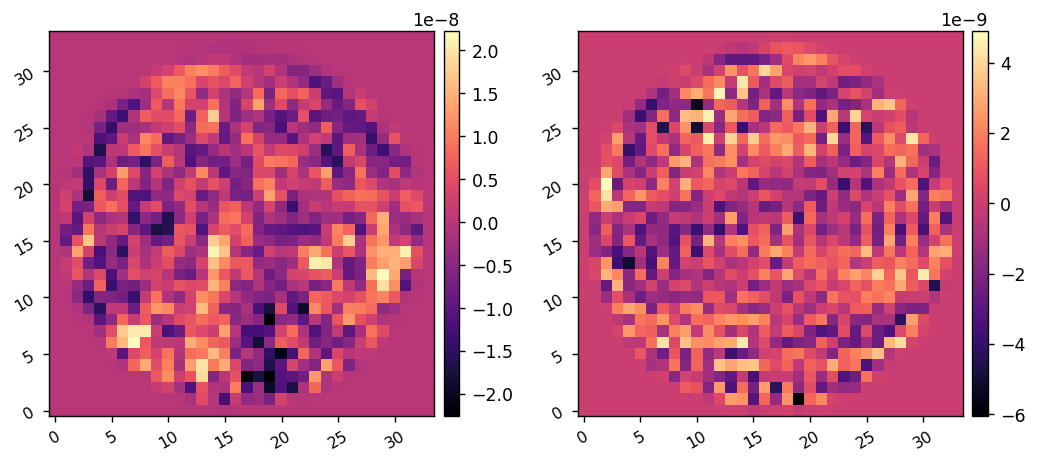

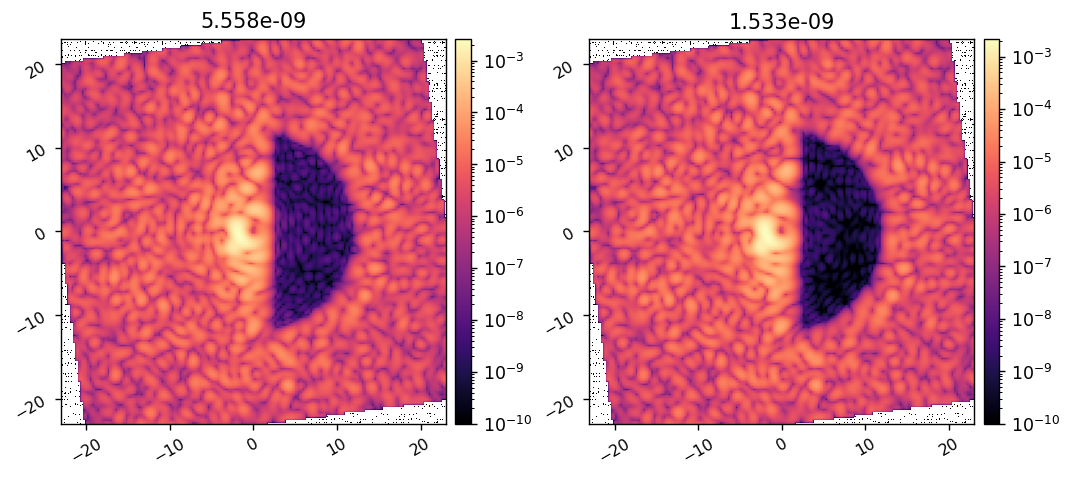

In [89]:
old_command = rmad.acts_to_command(acts, I.dm_mask)
del_command = rmad.acts_to_command(res.x, I.dm_mask)
print(del_command[25,21])

I.set_dm(old_command)
old_im = I.snap()
I.set_dm(old_command + del_command)
new_im = I.snap()

imshow2(old_command, del_command)
imshow2(old_im, new_im, 
        f'{xp.mean(old_im[control_mask]):.3e}', f'{xp.mean(new_im[control_mask]):.3e}',
        lognorm=True, pxscl=I.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [90]:
utils.save_fits('ad_test_acts.fits', I.get_dm()[I.dm_mask])

Saved data to:  ad_test_acts.fits
